**Galaxy Density Evolution Analysis Across Snapshots**

Plotting the radial density profiles of MW and M31 using Enclosed Mass, KDE, Nearest-Neighbor, Octree, and Delaunay methods

In [1]:
import os
os.chdir(r"D:\Abhinav Tar Files\Snapshots")

Processed 1/601 snapshots (s = 0)
Processed 2/601 snapshots (s = 1)
Processed 3/601 snapshots (s = 2)
Processed 4/601 snapshots (s = 3)
Processed 5/601 snapshots (s = 4)
Processed 6/601 snapshots (s = 5)
Processed 7/601 snapshots (s = 6)
Processed 8/601 snapshots (s = 7)
Processed 9/601 snapshots (s = 8)
Processed 10/601 snapshots (s = 9)
Processed 11/601 snapshots (s = 10)
Processed 12/601 snapshots (s = 11)
Processed 13/601 snapshots (s = 12)
Processed 14/601 snapshots (s = 13)
Processed 15/601 snapshots (s = 14)
Processed 16/601 snapshots (s = 15)
Processed 17/601 snapshots (s = 16)
Processed 18/601 snapshots (s = 17)
Processed 19/601 snapshots (s = 18)
Processed 20/601 snapshots (s = 19)
Processed 21/601 snapshots (s = 20)
Processed 22/601 snapshots (s = 21)
Processed 23/601 snapshots (s = 22)
Processed 24/601 snapshots (s = 23)
Processed 25/601 snapshots (s = 24)
Processed 26/601 snapshots (s = 25)
Processed 27/601 snapshots (s = 26)
Processed 28/601 snapshots (s = 27)
Processed 2

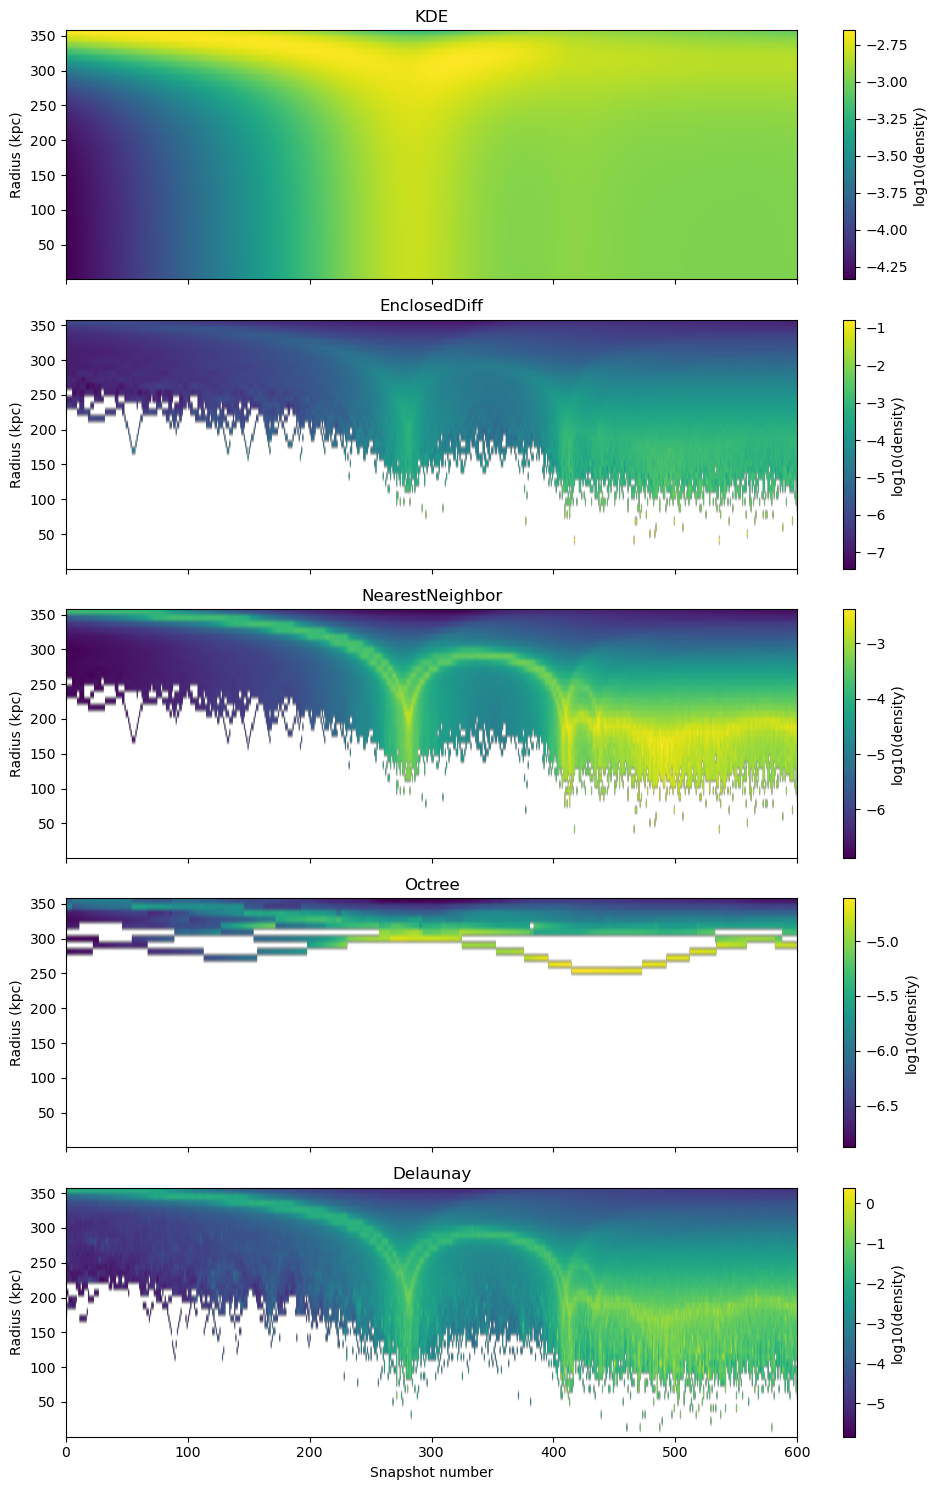

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ReadFile import Read
from CenterOfMass2 import CenterOfMass
from scipy.stats import gaussian_kde
from scipy.spatial import cKDTree, Delaunay
import warnings

warnings.filterwarnings("ignore")

start_snap = 0
end_snap = 600
snaps = np.arange(start_snap, end_snap + 1)
nsnaps = len(snaps)

r_bins = np.logspace(-1, 2.6, 40)
r_mid = np.sqrt(r_bins[:-1] * r_bins[1:])
nbins = len(r_mid)

dens_kde_all = np.full((nsnaps, nbins), np.nan)
dens_enc_all = np.full((nsnaps, nbins), np.nan)
dens_nn_all = np.full((nsnaps, nbins), np.nan)
dens_oct_all = np.full((nsnaps, nbins), np.nan)
dens_del_all = np.full((nsnaps, nbins), np.nan)

processed = 0

for i, s in enumerate(snaps):
    mw_file = f"MW_{s:03d}.txt"
    m31_file = f"M31_{s:03d}.txt"

    # Try to load snapshot
    try:
        MW = CenterOfMass(mw_file, 1)
        M31 = CenterOfMass(m31_file, 1)
        processed += 1
        print(f"Processed {processed}/{nsnaps} snapshots (s = {s})")
    except Exception:
        continue

    x = np.concatenate((MW.x, M31.x))
    y = np.concatenate((MW.y, M31.y))
    z = np.concatenate((MW.z, M31.z))
    m = np.concatenate((MW.m, M31.m))
    pos = np.vstack((x, y, z)).T

    xcom, ycom, zcom = MW.COMdefine(x, y, z, m)
    pos -= np.array([xcom, ycom, zcom])

    r = np.linalg.norm(pos, axis=1)

    # Method: Enclosed mass / differential density
    try:
        cumM = np.array([np.sum(m[r <= R]) for R in r_bins])
        dens_enc = np.diff(cumM) / ((4.0/3.0) * np.pi * (r_bins[1:]**3 - r_bins[:-1]**3))
        dens_enc_all[i, :] = dens_enc
    except Exception:
        pass

    # Method: KDE
    try:
        weights = m / np.sum(m)
        kde = gaussian_kde(r, weights=weights)
        dens_kde = kde(r_mid)
        dens_kde_all[i, :] = dens_kde
    except Exception:
        pass

    # Method: Nearest-neighbor
    try:
        tree = cKDTree(pos)
        k = 32
        distances, _ = tree.query(pos, k=k)
        rN = distances[:, -1]
        vol = (4.0/3.0) * np.pi * rN**3
        dens_particles = (k * np.mean(m)) / vol
        inds = np.digitize(r, bins=r_bins) - 1
        for b in range(nbins):
            mask = inds == b
            if np.sum(mask) > 0:
                dens_nn_all[i, b] = np.nanmean(dens_particles[mask])
    except Exception:
        pass

    # Method: Octree
    try:
        def octree_cells(positions, masses, max_particles=200, max_depth=8):
            mins = positions.min(axis=0)
            maxs = positions.max(axis=0)
            cells = [(mins, maxs, np.arange(len(positions)), 0)]
            centers = []
            dens = []
            while cells:
                mn, mx, idxs, depth = cells.pop()
                n = idxs.size
                vol = np.prod(mx - mn)
                if n <= max_particles or depth >= max_depth or vol == 0:
                    mass = np.sum(masses[idxs]) if n > 0 else 0.0
                    if vol > 0 and mass > 0:
                        centers.append((mn + mx) / 2.0)
                        dens.append(mass / vol)
                    continue
                mid = (mn + mx) / 2.0
                for ix in range(2):
                    for iy in range(2):
                        for iz in range(2):
                            low = mn.copy()
                            high = mx.copy()
                            low[0] = mn[0] if ix == 0 else mid[0]
                            high[0] = mid[0] if ix == 0 else mx[0]
                            low[1] = mn[1] if iy == 0 else mid[1]
                            high[1] = mid[1] if iy == 0 else mx[1]
                            low[2] = mn[2] if iz == 0 else mid[2]
                            high[2] = mid[2] if iz == 0 else mx[2]
                            pts = positions[idxs]
                            if pts.size == 0:
                                continue
                            mask = np.all((pts >= low) & (pts < high), axis=1)
                            child_idxs = idxs[mask]
                            if child_idxs.size > 0:
                                cells.append((low, high, child_idxs, depth+1))
            if len(centers) == 0:
                return np.array([]), np.array([])
            centers = np.array(centers)
            dens = np.array(dens)
            return centers, dens

        centers, cell_dens = octree_cells(pos, m, max_particles=150, max_depth=7)
        if centers.size:
            radii_cells = np.linalg.norm(centers, axis=1)
            inds = np.digitize(radii_cells, bins=r_bins) - 1
            for b in range(nbins):
                mask = inds == b
                if np.sum(mask) > 0:
                    dens_oct_all[i, b] = np.nanmean(cell_dens[mask])
    except Exception:
        pass

    # Method: Delaunay
    try:
        tri = Delaunay(pos)
        simplices = tri.simplices
        pts = pos
        tetra = pts[simplices]
        vols = np.abs(np.linalg.det(tetra[:,1:] - tetra[:,0,None])) / 6.0
        tetra_m = m[simplices].sum(axis=1)
        tetra_dens = tetra_m / vols
        centroids = tetra.mean(axis=1)
        radii_cent = np.linalg.norm(centroids, axis=1)
        inds = np.digitize(radii_cent, bins=r_bins) - 1
        for b in range(nbins):
            mask = inds == b
            if np.sum(mask) > 0:
                dens_del_all[i, b] = np.nanmean(tetra_dens[mask])
    except Exception:
        pass

# plotting heatmaps
methods = [
    ("KDE", dens_kde_all),
    ("EnclosedDiff", dens_enc_all),
    ("NearestNeighbor", dens_nn_all),
    ("Octree", dens_oct_all),
    ("Delaunay", dens_del_all),
]

fig, axes = plt.subplots(len(methods), 1, figsize=(10, 3*len(methods)), sharex=True)
for ax, (name, data) in zip(axes, methods):
    im = ax.imshow(np.log10(np.where(data > 0, data, np.nan)).T,
                   origin="lower", aspect="auto",
                   extent=[snaps[0], snaps[-1], r_mid[0], r_mid[-1]],
                   cmap="viridis")
    ax.set_ylabel("Radius (kpc)")
    ax.set_title(name)
    fig.colorbar(im, ax=ax, label='log10(density)')

axes[-1].set_xlabel("Snapshot number")
plt.tight_layout()
plt.savefig("density_methods_evolution_heatmaps.png", dpi=300)
plt.show()
